## 画像コンペ

In [1]:
import os

basepath = "../first_retailing/"
img_files = os.listdir(basepath+"train/")

In [2]:
#訓練データの正解データ
from PIL import Image
import pandas as pd
import seaborn as sns
import numpy as np
%matplotlib inline

train = pd.read_csv(basepath+"train_master.tsv", sep="\t")

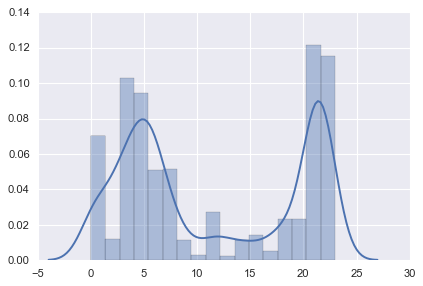

In [3]:
#histogram
sns.distplot(train["category_id"].values)

In [4]:
#utils
#画像のpixelを作成
def get_img_array(path,resize):
    img_array = Image.open(path).resize([resize,resize]).getdata()
    return img_array

#画像を表示
def show_img(path):
    img_array = Image.open(path).resize([128,128])
    img_array.show()

#精度
def M_accuracy(train, pred):
    pred_dict = {v:0 for v in range(len(color_list))}
    num_dict = {v:0 for v in range(len(color_list))}
    for i in range(len(pred)):
        if train["category_id"].values[i] == pred[i]:
            pred_dict[train["category_id"].values[i]] = pred_dict[train["category_id"].values[i]] + 1
            num_dict[train["category_id"].values[i]] = num_dict[train["category_id"].values[i]] + 1
        else:
            num_dict[train["category_id"].values[i]] = num_dict[train["category_id"].values[i]] + 1
    return np.mean([pred_dict[k]/num_dict[k] for k in range(len(pred_dict)) if num_dict[k] != 0])


#pickle書き出し(<4GB)
import pickle
def write_pickle(pickle_path,v):
    with open(pickle_path, mode='wb') as f:
        pickle.dump(v, f)
    print("Finished Writing pickle")

#pickle 読み込み 
def read_pickle(pickle_path):
    with open(pickle_path, mode='rb') as f:
        read = pickle.load(f)
    return read

## データ準備(128*128)

In [6]:
import numpy as np

X = []
for i in range(len(img_files)):
    X.append(np.hstack(get_img_array(basepath + "train/train_%s.jpg"%(i), 128)))

In [11]:
X = pd.DataFrame(X)

In [12]:
X.shape #(サンプル数,128*128*3)

(12399, 49152)

In [11]:
from sklearn.cross_validation import train_test_split

X_train,X_valid,y_train,y_valid = train_test_split(X, train, test_size=0.5,random_state=0)

/Users/Chang/.pyenv/versions/python351/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [14]:
X_train.shape

(6199, 49152)

In [5]:
#X_train.to_csv(basepath+"X_train.csv")
#X_valid.to_csv(basepath+"X_valid.csv")
#y_train.to_csv(basepath+"y_train.csv")
#y_valid.to_csv(basepath+"y_valid.csv")


X_train = pd.read_csv("../X_train.csv")
X_valid = pd.read_csv("../X_valid.csv")
y_train = pd.read_csv("../y_train.csv")
y_valid = pd.read_csv("../y_valid.csv")

## CNN

In [6]:
def preprocessing_for_keras(X):
    X_n = X/255
    X_n.astype("float32")
    X_n = X_n.values.reshape(X.shape[0], 3, 128, 128)    
    return X_n

In [7]:
#X_train, X_validはcsvファイル経由だと一番左にゴミがある
X_train_keras = preprocessing_for_keras(X_train.iloc[:,1:])

In [8]:
X_valid_keras = preprocessing_for_keras(X_valid.iloc[:,1:])

In [ ]:
#CNN
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD
from keras.utils import np_utils
import keras 

batch_size = 1024
nb_classes = len(np.unique(y_train["value"]))
nb_epoch = 20
data_augmentation = True
input_shape = (3, 128, 128)

# input image dimensions
img_rows, img_cols = 128, 128
# the CIFAR10 images are RGB
img_channels = 3

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_valid.shape[0], 'train samples')

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train["value"].values, nb_classes)
Y_valid  = np_utils.to_categorical(y_valid["value"].values ,  nb_classes)
#Y_test  = np_utils.to_categorical(y_test.values ,  nb_classes)

#callbacks
es_cb = keras.callbacks.EarlyStopping(monitor='val_loss', patience=0, verbose=1, mode='auto')
sv_cb = keras.callbacks.ModelCheckpoint(basepath+"weight/weights_{epoch:02d}-{val_loss:.2f}.hdf5", monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto')

model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=input_shape, padding="same"))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3),padding="same"))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))


# let's train the model using SGD + momentum (how original).
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

model.summary()


if not data_augmentation:
    print('Not using data augmentation.')
    history = model.fit(X_train_keras, Y_train,
              batch_size=batch_size,
              epochs=nb_epoch,
              validation_data=(X_valid_keras,  Y_valid),
              shuffle=True,
              callbacks=[es_cb, sv_cb])
    
    
else:
    print('Using real-time data augmentation.')

    # this will do preprocessing and realtime data augmentation
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

    # compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied)
    datagen.fit(X_valid_keras)

    # fit the model on the batches generated by datagen.flow()
    history = model.fit_generator(datagen.flow(X_train_keras, Y_train,
                        batch_size=batch_size),
                        samples_per_epoch=X_valid_keras.shape[0],
                        nb_epoch=nb_epoch,
                        validation_data=(X_valid_keras, Y_valid),
                        callbacks=[es_cb, sv_cb])

X_train shape: (6199, 49153)
6199 train samples
6200 train samples
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 128, 128)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 128, 128)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 126, 126)      9248      
_________________________________________________________________
activation_2 (Activation)    (None, 32, 126, 126)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 63, 63)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 63, 63)        0         
_________________________________________________________________
conv2d_3 